In [1]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import torch.optim as optim
from tqdm import tqdm  # For nice progress bar!
import matplotlib.pyplot as plt
import numpy as np
from fxpmath import Fxp # conver to fixed point

In [2]:
tf = transforms.Compose([ToTensor()])
mnist_train = datasets.MNIST('mnist_data/', download=True, train=True, transform=tf)
mnist_test = datasets.MNIST('mnist_data/', download=True, train=False, transform=tf)

### Reduced targeted labels

In [3]:
targets = [0, 1, 2]
train_indices = [i for i, label in enumerate(mnist_train.targets) if label in targets]
mnist_train_sub = Subset(mnist_train, train_indices)
test_indices = [i for i, label in enumerate(mnist_test.targets) if label in targets]
mnist_test_sub = Subset(mnist_test, test_indices)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


In [5]:
train_set = torch.utils.data.DataLoader(mnist_train_sub, batch_size=256, shuffle=True)
test_set = torch.utils.data.DataLoader(mnist_test_sub, batch_size=256, shuffle=True)

## First version of CNN

In [ ]:
mg_size = 16
hidden_size = 16

class ConvNN(nn.Module):
    def __init__(self):
        super(ConvNN, self).__init__()
        self.conv = nn.Conv2d(1, 1, (3,3), stride=2)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=1)
        self.NN = nn.Linear(hidden_size, 10, bias=False)
        

    def forward(self, x):
        x = F.relu(self.conv(x))
        x = self.pool1(x)
        x = self.pool2(x)
        x = x.reshape(x.shape[0], -1)
        x = self.NN(x)
        return x
    
# Test
x = torch.randn(256, 1, 28, 28)
model = ConvNN()
print(model(x).shape)

In [41]:
model = ConvNN().to(device)
print(model)

ConvNN(
  (conv): Conv2d(1, 1, kernel_size=(3, 3), stride=(2, 2))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (NN): Linear(in_features=16, out_features=10, bias=False)
)


In [68]:
# hyperparameters
num_epochs = 100
learning_rate = 1e-3

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

epoch_scores = []
epoch_loss = []

# Train Network
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(tqdm(train_set)):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        epoch_scores.append(scores)
        loss = criterion(scores, targets)
        epoch_loss.append(loss)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

# Check accuracy on training & test to see how good our model
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    model.train()
    return num_correct / num_samples


print(f"Accuracy on training set: {check_accuracy(train_set, model)*100:.2f}%")
print(f"Accuracy on test set: {check_accuracy(test_set, model)*100:.2f}%")

100%|██████████| 235/235 [00:27<00:00,  8.40it/s]


Accuracy on training set: 69.76%
Accuracy on test set: 70.09%


In [ ]:
torch.save(model, 'trained_CNNv1.pth')

## Second version of CNN

In [4]:
mg_size = 16
hidden_size = 16

class ConvNNv2(nn.Module):
    def __init__(self):
        super(ConvNNv2, self).__init__()
        self.conv = nn.Conv2d(1, 1, (5,5), stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=(3, 3), stride=3)
        self.NN = nn.Linear(hidden_size, 10, bias=False)
        

    def forward(self, x):
        x = F.relu(self.conv(x))
        x = self.pool1(x)
        x = self.pool2(x)
        x = x.reshape(x.shape[0], -1)
        x = self.NN(x)
        return x

# Test
x = torch.randn(256, 1, 28, 28)
model = ConvNNv2()
print(model(x).shape)

torch.Size([256, 10])


In [76]:
model = ConvNNv2().to(device)
print(model)

ConvNNv2(
  (conv): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=(3, 3), stride=3, padding=0, dilation=1, ceil_mode=False)
  (NN): Linear(in_features=16, out_features=10, bias=False)
)


In [79]:
# hyperparameters
num_epochs = 100
learning_rate = 1e-3

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

epoch_scores = []
epoch_loss = []

# Train Network
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(tqdm(train_set)):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        epoch_scores.append(scores)
        loss = criterion(scores, targets)
        epoch_loss.append(loss)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
        
# Check accuracy on training & test to see how good our model
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    model.train()
    return num_correct / num_samples


print(f"Accuracy on training set: {check_accuracy(train_set, model)*100:.2f}%")
print(f"Accuracy on test set: {check_accuracy(test_set, model)*100:.2f}%")

100%|██████████| 235/235 [01:51<00:00,  2.10it/s]


Accuracy on training set: 78.92%
Accuracy on test set: 80.20%


In [ ]:
plt.plot(epoch_losses)

## Third version of CNN

In [6]:
mg_size = 16
hidden_size = 16

class ConvNNv3(nn.Module):
    def __init__(self):
        super(ConvNNv3, self).__init__()
        self.conv = nn.Conv2d(1, 1, (7,7), stride=7)
        self.NN = nn.Linear(hidden_size, 3, bias=False)
        

    def forward(self, x):
        x = F.relu(self.conv(x))
        x = x.reshape(x.shape[0], -1)
        x = self.NN(x)
        return x

# Test
x = torch.randn(256, 1, 28, 28)
model = ConvNNv3()
print(model(x).shape)

torch.Size([256, 3])


In [38]:
# hyperparameters
num_epochs = 100
learning_rate = 1e-3

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

epoch_scores = []
epoch_loss = []

# Train Network
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(tqdm(train_set)):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        epoch_scores.append(scores)
        loss = criterion(scores, targets)
        epoch_loss.append(loss)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
        
# Check accuracy on training & test to see how good our model
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    model.train()
    return num_correct / num_samples


print(f"Accuracy on training set: {check_accuracy(train_set, model)*100:.2f}%")
print(f"Accuracy on test set: {check_accuracy(test_set, model)*100:.2f}%")

100%|██████████| 73/73 [00:05<00:00, 12.74it/s]


Accuracy on training set: 96.94%
Accuracy on test set: 97.20%


### Save the model

In [1]:
torch.save(model, 'trained_model_CNNv3.pth')
torch.save(model.state_dict(), 'trained_model_CNNv3_stateDict.pth')

convWeights = model.conv.weight
NNWeights = model.NN.weight
NNBias = model.NN.bias
print(f"Conv weights are: {convWeights.data.numpy()}")
print()
print(f"NN weights are: {NNWeights.data.numpy()}")
print()
print(f"NN bias are: {NNBias.data.numpy()}")# there is no bias activated

NameError: name 'torch' is not defined

### Load the trained model

In [7]:
model = ConvNNv3().to(device)
model = torch.load('trained_model_CNNv3.pth', map_location=torch.device(device))
print(f"{model}\n")
convWeights = model.conv.weight
NNWeights = model.NN.weight
NNBias = model.NN.bias
print(f"Conv weights are: {convWeights.data.numpy()}")
print()
print(f"NN weights are: {NNWeights.data.numpy()}")

ConvNNv3(
  (conv): Conv2d(1, 1, kernel_size=(7, 7), stride=(7, 7))
  (NN): Linear(in_features=16, out_features=3, bias=False)
)

Conv weights are: [[[[-1.1298487  -0.27229133  0.28714627  0.37493512  0.907366
     0.1431789   0.5347539 ]
   [-0.2581845  -0.4241132  -0.10635767 -0.34131074  0.02841576
     0.21795687  1.1256728 ]
   [ 0.08687092 -0.12886696 -0.18294106  0.01583078  0.14978798
     0.2600748   1.822983  ]
   [ 0.02083484 -0.23739645 -0.07607995  0.03428378  0.33496696
     0.12257625  1.507085  ]
   [ 0.09251168 -0.10718158  0.1141251   0.16347924  0.19863708
     0.08806781  1.1991171 ]
   [ 0.19172686 -0.1688782  -0.16837654  0.19224697  0.09232251
    -0.24064474  0.6898716 ]
   [ 0.11634796  0.15621877  0.32756346  0.45236462 -0.01670279
    -0.03087329  1.1322131 ]]]]

NN weights are: [[-1.1708761  -0.11018552 -0.1340647  -0.06756116  0.3034926   0.22939438
   0.22623716 -0.06675144  0.6924737  -0.80566144  0.787699   -0.96738493
  -0.4626782   0.55083805 -0.019357

In [8]:
convBias = Fxp(model.state_dict()['conv.bias'].data.numpy(), signed=True, n_int=15, n_frac=16)
convBias.hex()

['0x0001DA4C']

### Convert to Fixed point Q7.8 (signed)

In [28]:
def weightsToVHDL(listWeights):
    listWeights = np.flip(listWeights)
    outputStr = "("
    for row in listWeights:
        for weight in row:
            outputStr += f'X"{weight[2:]}", '
        outputStr += "\n "
    outputStr = outputStr[0:-4]
    outputStr += ");\n"
    print(outputStr)

In [29]:
def ValsToHFile(listVals, varName):
    outputStr = f"static uint16_t {varName}[] = " + "{\n"
    for row in listVals:
        for val in row:
            outputStr += f'{val}, '
            # print(weight)
        outputStr += "\n "
    outputStr = outputStr[0:-4]
    outputStr += "\n};"
    print(outputStr, "\n")
    pass

# Just below here Zehao

In [30]:
fxpconvWeights = Fxp(convWeights.data.numpy()[0], signed=True, n_int=7, n_frac=8)
fxpNNWeights = Fxp(NNWeights.data.numpy(), signed=True, n_int=7, n_frac=8)
# fxpconvWeights = Fxp(convWeights.data.numpy()[0], signed=True, n_int=7, n_frac=8)
# fxpNNWeights = Fxp(NNWeights.data.numpy(), signed=True, n_int=7, n_frac=8)

print(f"Covolutional filter weights:")
weightsToVHDL(fxpconvWeights.hex()[0])

print(f"\nNN weights:")
#weightsToVHDL(fxpNNWeights.hex())
ValsToHFile(fxpNNWeights.hex(), "nnWeights")

""" Just for testing """
# test_image1 = np.flip(imgs[idx1].data.numpy()[0])
# rearranged_test_image1 = rearrange_image_for_memory(test_image1, 7)
# fxpTest_image1 = Fxp(rearranged_test_image1, signed=True, n_int=7, n_frac=8)
# print("testImage1:")
# weightsToVHDL(fxpTest_image1.hex())

# test_image0 = np.flip(imgs[idx0].data.numpy()[0])
# rearranged_test_image0 = rearrange_image_for_memory(test_image0, 7)
# fxpTest_image0 = Fxp(rearranged_test_image0, signed=True, n_int=7, n_frac=8)
# print("testImage0:")
# weightsToVHDL(fxpTest_image0.hex())

# test_image2 = np.flip(imgs[idx2].data.numpy()[0])
# rearranged_test_image2 = rearrange_image_for_memory(test_image2, 7)
# fxpTest_image2 = Fxp(rearranged_test_image2, signed=True, n_int=7, n_frac=8)
# print("testImage2:")
# weightsToVHDL(fxpTest_image2.hex())

Covolutional filter weights:
(X"0121", X"FFF9", X"FFFC", X"0073", X"0053", X"0027", X"001D", 
 X"00B0", X"FFC3", X"0017", X"0031", X"FFD5", X"FFD5", X"0031", 
 X"0132", X"0016", X"0032", X"0029", X"001D", X"FFE5", X"0017", 
 X"0181", X"001F", X"0055", X"0008", X"FFED", X"FFC4", X"0005", 
 X"01D2", X"0042", X"0026", X"0004", X"FFD2", X"FFE0", X"0016", 
 X"0120", X"0037", X"0007", X"FFA9", X"FFE5", X"FF94", X"FFBE", 
 X"0088", X"0024", X"00E8", X"005F", X"0049", X"FFBB", X"FEDF");


NN weights:
static uint16_t nnWeights[] = {
0xFED5, 0xFFE4, 0xFFDE, 0xFFEF, 0x004D, 0x003A, 0x0039, 0xFFEF, 0x00B1, 0xFF32, 0x00C9, 0xFF09, 0xFF8A, 0x008D, 0xFFFC, 0xFF63, 
 0x0095, 0xFF60, 0xFFD6, 0x015F, 0xFF9B, 0x0005, 0xFF6F, 0xFFED, 0xFF6C, 0x003E, 0xFE6C, 0x006D, 0x0034, 0xFFB8, 0xFFC7, 0x012A, 
 0xFFC3, 0x008C, 0xFFBA, 0xFE48, 0x0010, 0xFF9D, 0x0003, 0x0008, 0x0095, 0x004E, 0x00B3, 0x0044, 0xFFE9, 0xFFE4, 0x0038, 0xFF0F
}; 



' Just for testing '

### Convolution filter test bench

In [35]:
def test_all_1(conv_weights):
    conv_res = Fxp(0, signed=True, n_int=15, n_frac=16)
    for row in conv_weights:
        for weight in row:
            conv_res += weight
    return conv_res

def test_all_i(conv_weights):
    conv_res = Fxp(0, signed=True, n_int=15, n_frac=16)
    for i in range(len(conv_weights)):
        for j in range(len(conv_weights[0])):
            # print(conv_res)
            conv_res(conv_res + conv_weights[i][j]*(i+j))
            conv_res.resize(True, n_int=15, n_frac=16)
    return conv_res

def convolve(image, conv_filter):
    convolved_res = []
    for i in range(len(image)/len(conv_filter)):
        convolved_res.append(Fxp(np.multiply(image[i*len(conv_filter): i*len(conv_filter)], conv_filter, signed=True, n_int=7, n_frac=8)))
    print(convolved_res)
    
print(test_all_1(fxpconvWeights[0]))
x = test_all_i(fxpconvWeights[0])
# x.resize(True, 7, 8)
print(x.info(verbose=3))
x.resize()

22.265625
	dtype		=	fxp-s32/16
	Value		=	165.08984375
	extended_prec	=	True

	Signed		=	True
	Word bits	=	32
	Fract bits	=	16
	Int bits	=	15
	Val data type	=	<class 'float'>

	Upper		=	32767.99998474121
	Lower		=	-32768.0
	Precision	=	1.52587890625e-05
	Overflow	=	saturate
	Rounding	=	trunc
	Shifting	=	expand

None


## Select a random image for hardware test

In [12]:
import random
imgs, labs = next(iter(test_set))
idx = random.randint(0, len(imgs))

torch.Size([256, 1, 28, 28]) torch.Size([256]) image id: 60
12.6 µs ± 2.93 µs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
predicted: tensor([[  7.3093, -14.1804,  -1.5944]], grad_fn=<MmBackward0>) vs label: 0


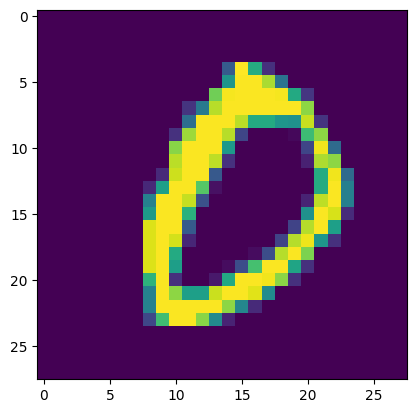

In [18]:
idx0 = 60
print(imgs.shape, labs.shape, f"image id: {idx0}")
plt.imshow(imgs[idx0].squeeze())
pred0 = model(imgs[idx0].to(device))
%timeit prediction = torch.argmax(pred0.cpu()) #Check how long it takes to predicit
prediction0 = pred0.cpu()
print(f"predicted: {prediction0} vs label: {labs[idx0]}")

torch.Size([256, 1, 28, 28]) torch.Size([256]) image id: 205
predicted: 2 vs label: 2


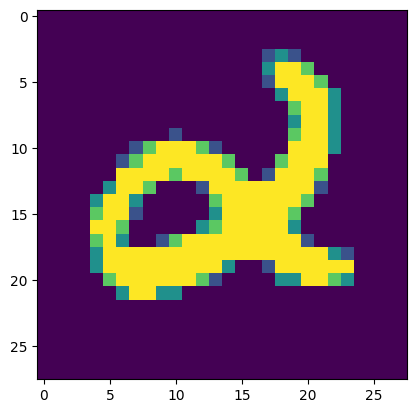

In [21]:
idx2 = 205
print(imgs.shape, labs.shape, f"image id: {idx2}")
plt.imshow(imgs[idx2].squeeze())
pred2 = model(imgs[idx2].to(device))
#%timeit prediction = torch.argmax(pred2.cpu()) #Check how long it takes to predicit
prediction2 = torch.argmax(pred2.cpu())
print(f"predicted: {prediction2} vs label: {labs[idx2]}")

torch.Size([256, 1, 28, 28]) torch.Size([256]) image id: 7
21.5 µs ± 2.89 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
predicted: 1 vs label: 1
predictions:tensor([[-8.2463,  3.8467, -2.9030]], grad_fn=<MmBackward0>)


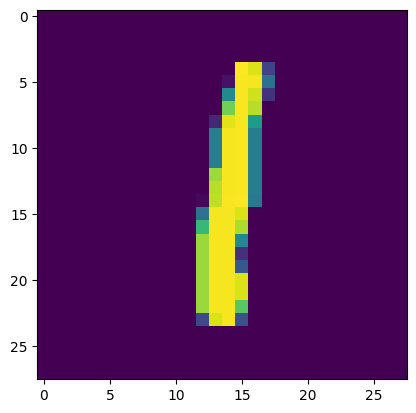

In [25]:
idx1 = 7
print(imgs.shape, labs.shape, f"image id: {idx1}")
plt.imshow(imgs[idx1].squeeze())
pred1 = model(imgs[idx1].to(device))
%timeit prediction = torch.argmax(pred1.cpu()) #Check how long it takes to predicit
prediction1 = torch.argmax(pred1.cpu())
print(f"predicted: {prediction1} vs label: {labs[idx1]}")
print(f"predictions:{pred1.cpu()}")

In [26]:
def rearrange_image_for_memory(image, window_width):
    nbWindowRows = int(len(image)/window_width) # assuming both are square
    nbWindowCols = int(len(image[0])/window_width) # assuming both are square
    rearranged_image = np.zeros((nbWindowRows*nbWindowCols, window_width**2)) # each new row in array is a new window
    for i in range(nbWindowRows):
        for j in range(nbWindowCols):
            rearranged_image[i*nbWindowCols + j, :] = image[i*window_width:(i+1)*window_width, j*window_width:(j+1)*window_width].flatten()
    return rearranged_image

# tester = np.reshape(np.arange(4*4),(4,4))
# tester_window = int(2)
# print(tester)
# rearrange_image_for_memory(tester, tester_window)

In [27]:
test_image0 = imgs[idx0].data.numpy()[0]
test_image1 = imgs[idx1].data.numpy()[0]
test_image2 = imgs[idx2].data.numpy()[0]

rearranged_test_image0 = rearrange_image_for_memory(test_image0, 7)
fxpTest_image0 = Fxp(rearranged_test_image0, signed=True, n_int=7, n_frac=8)

rearranged_test_image1 = rearrange_image_for_memory(test_image1, 7)
fxpTest_image1 = Fxp(rearranged_test_image1, signed=True, n_int=7, n_frac=8)

rearranged_test_image2 = rearrange_image_for_memory(test_image2, 7)
fxpTest_image2 = Fxp(rearranged_test_image2, signed=True, n_int=7, n_frac=8)

ValsToHFile(fxpTest_image0.hex(), "testImage0")
ValsToHFile(fxpTest_image1.hex(), "testImage1")
ValsToHFile(fxpTest_image2.hex(), "testImage2")

static uint16_t testImage0[] = {
0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 
 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x00C7, 
 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0

In [40]:
weightsToVHDL(fxpTest_image0.hex())
weightsToVHDL(fxpTest_image1.hex())
weightsToVHDL(fxpTest_image2.hex())


(X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", 
 X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0098", X"00FE", X"00FE", X"00FE", X"0000", X"0000", X"0000", X"003D", X"0052", X"00E4", X"00FD", X"0000", X"0000", X"0000", X"0000", X"0035", X"00ED", X"00FD", 
 X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"0000", X"000

In [39]:
print(len(fxpTest_image0.hex()[0]))

49


In [ ]:
tf = transforms.Compose([
    ToTensor(), 
    transforms.CenterCrop(240), 
    transforms.Resize(16), 
    lambda x: transforms.functional.rotate(x, 180)
])
custom_test = datasets.ImageFolder('custom_data/', transform=tf)